In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from pyMPM import MPM

# 1. Attenuation by water vapor over for MW range from 1 GHz to 100 GHz

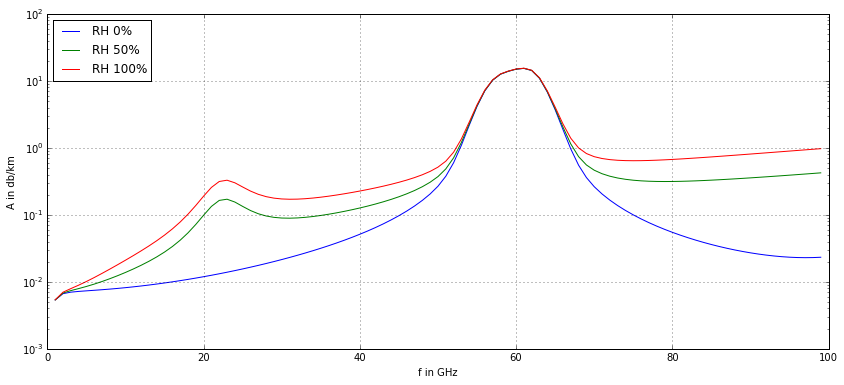

In [3]:
figsize(14,6)

f = arange(1,100)     # Vector of frequencies in GHz
T = 15                # Air temperature in degree Celcius
P = 1013              # Air pressiure in mbar
RH_vec = [0, 50, 100] # List of relative humidity values used for plotting

for RH in RH_vec:
    A = MPM(f, P, T, RH, 0, 0, 0, 'att')
    semilogy(f,A, label='RH ' + str(RH) + '%')

xlabel('f in GHz')
ylabel('A in db/km')
legend(loc=2)
grid()

# 2. Attenuation vs. RH for three frequencies and RH from 0% to 100%

In [4]:
f_vec = [15,22.235,30]# Vector of frequencies in GHz
T = 30                # Air temperature in degree Celcius
P = 1013              # Air pressiure in mbar
RH_vec = arange(100)  # Vector of relative humidity values

## 2.1 Calculate it

In [5]:
A_dict = {}
for f in f_vec:
    A = [MPM(f, P, T, RH, 0, 0, 0, 'att') for RH in RH_vec]
    A_dict[str(f) + 'GHz'] = A

## 2.2 Plot it

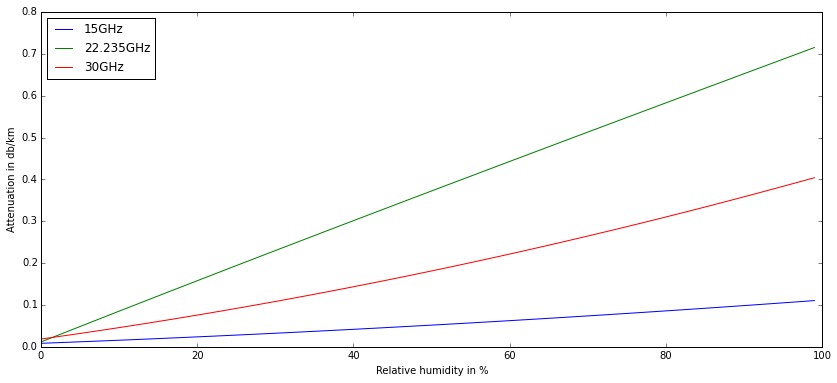

In [6]:
for f in f_vec:
    key = str(f) + 'GHz'
    plot(RH_vec, A_dict[key], label=key)
legend(loc=2)
xlabel('Relative humidity in %')
ylabel('Attenuation in db/km');

# 3. Attenuation vs. absolute humidity

## 3.1 Some functions to convert from RH to absolute humidity (=water vapor density)

In [7]:
def sat_water_vap_pres(T):
    '''
    sat_water_vap_pres(T)
    
    T     = Temperature in ∞C
    e_sat = Saturated water vapor pressure in HPa (=mbar)
    
    Calculates the saturated water vapor pressure with
    the approximation by Bolton (1980)
    '''
    import numpy as np
    return 6.112 * np.exp(17.67 * T / (T + 243.5))


def abs_hum(RH,T):
    '''
    Calculate absolute humidity from temperature and relative humidity
    
    abs_hum(rh,t)
    
    abs_hum = absolute humidity on g/m^3
    RH      = relative humidity in percent
    T       = temperature in degree C
    '''

    R = 8.3144621e-2 # gas constant in hPa*m^2/(mol*K)
    M = 18.02       # molar weight in g/mol
    TK = T + 273.15
    
    abs_h = RH / 100.0 * sat_water_vap_pres(T) * M / R / TK
    return abs_h


## 3.2 Plot it

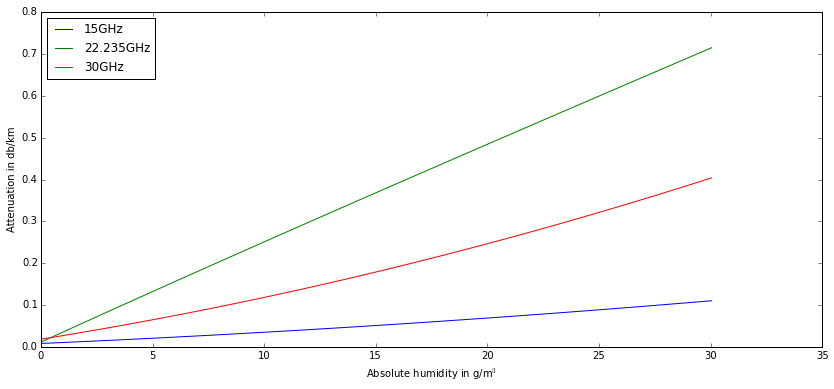

In [8]:
abs_hum_vec = abs_hum(RH_vec,T)

for f in f_vec:
    key = str(f) + 'GHz'
    plot(abs_hum_vec, A_dict[key], label=key)
legend(loc=2)
xlabel('Absolute humidity in g/m$^3$')
ylabel('Attenuation in db/km');

# 4. Fit linear relation between attenuation and absolute humidity

In [9]:
def fit_linear(xd,yd):
    # determine best fit line
    par = np.polyfit(xd, yd, 1, full=True)
    slope=par[0][0]
    intercept=par[0][1]
    return slope[0], intercept[0]

## 4.1 Plot fitted line in data from above

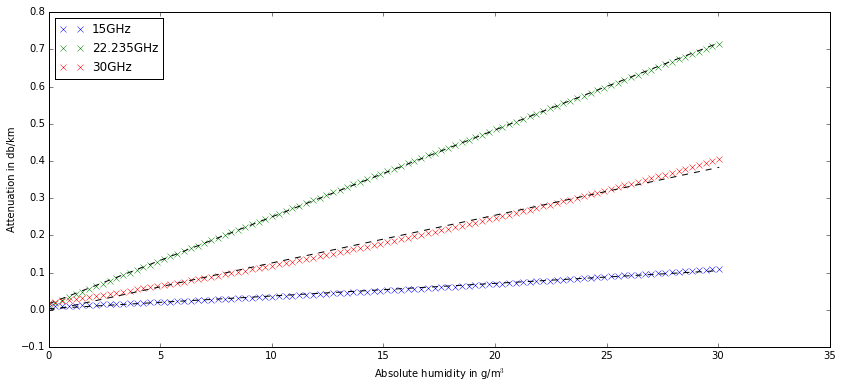

In [10]:
for f in f_vec:
    key = str(f) + 'GHz'
    plot(abs_hum_vec, A_dict[key], 'x', label=key)
    slope, intercept = fit_linear(abs_hum_vec, A_dict[key])
    plot(abs_hum_vec, intercept + slope*abs_hum_vec, 'k--')
legend(loc=2)
xlabel('Absolute humidity in g/m$^3$')
ylabel('Attenuation in db/km');

## 4.2 Plot fit parameters for different frequencies and temperatures

In [11]:
T_vec = [0,20,40]
f_vec = range(1,100,1)

P = 1013              # Air pressiure in mbar
RH_vec = arange(100)  # Vector of relative humidity values

fit_param_T = {}
for T in T_vec:
    abs_hum_vec = abs_hum(RH_vec, T)
    slope_vec = zeros_like(f_vec, dtype=float)
    intercept_vec = zeros_like(f_vec, dtype=float)
    for i_f,f in enumerate(f_vec):
        A = [MPM(f, P, T, RH, 0, 0, 0, 'att') for RH in RH_vec]
        slope_vec[i_f], intercept_vec[i_f] = fit_linear(abs_hum_vec, A)
    fit_param_T[str(T)] = {'slope': slope_vec,
                           'intercept': intercept_vec}
        

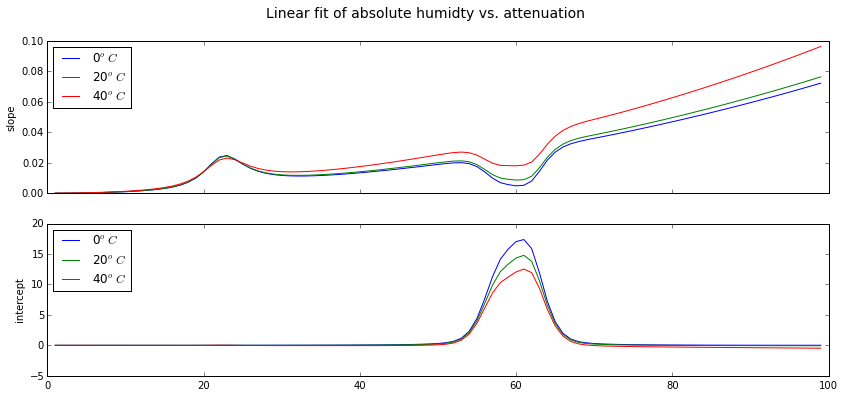

In [13]:
fig, ax = subplots(2,1, sharex=True)
for T in T_vec:
    ax[0].plot(f_vec, fit_param_T[str(T)]['slope'], label=str(T) + '$^oC$')
    ax[1].plot(f_vec, fit_param_T[str(T)]['intercept'], label=str(T) + '$^oC$')
fig.suptitle('Linear fit of absolute humidty vs. attenuation', fontsize=14)
ax[0].legend(loc=2)
ax[1].legend(loc=2)
ax[0].set_ylabel('slope')
ax[1].set_ylabel('intercept');

**Note that the linear fit is not a good approximation above 50 GHz since there, abs_hum vs. A has a more parabolic shape!!!**